In [1]:
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')


import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


# set root directory
ROOTDIR = Path.cwd().parent
# change directory to root directory
os.chdir(ROOTDIR)
print(ROOTDIR)

# import custom modules
from src.data import utils
from src.features.preprocessors import OutlierExtractor, RareLabelCategoricalEncoder, CategoricalEncoder

# set directories
DATADIR = ROOTDIR / 'data/raw'
MODELDIR = ROOTDIR / 'models'



f:\Data_Science_Projekte\Big_Mart_Sales_Prediction\big_mart_sales_prediction


# Problem Statement

## Big Mart is a worldwide grocery supermarket. For the year 2013, the data science team at Big Mart have collected the sales data for 1559 products across 10 stores in different cities. In addtion, different features of each store and product have been collected. Big Mart wants to use Data Science to find out what drives sales and how to predict them.

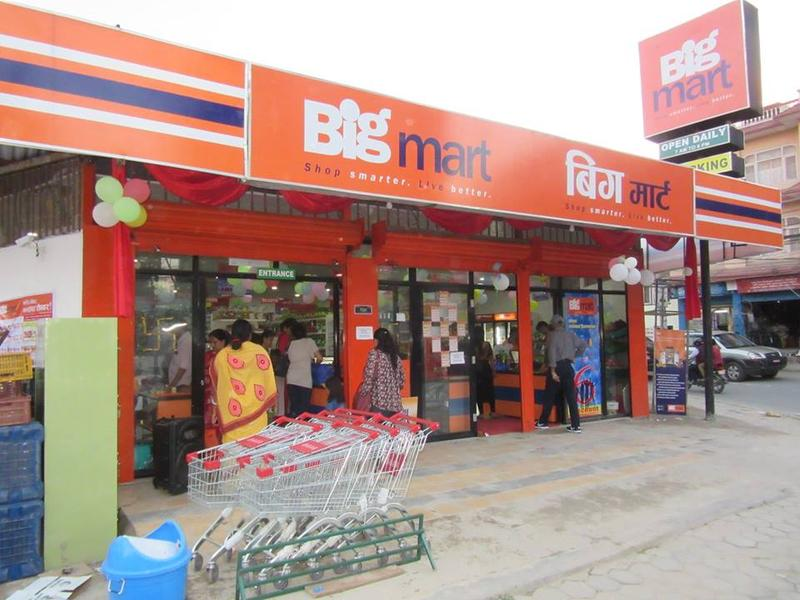

In [2]:
Image(filename=DATADIR/'big_mart_image.jpg') 

# Exploratory Data Analysis and Data Preprocessing

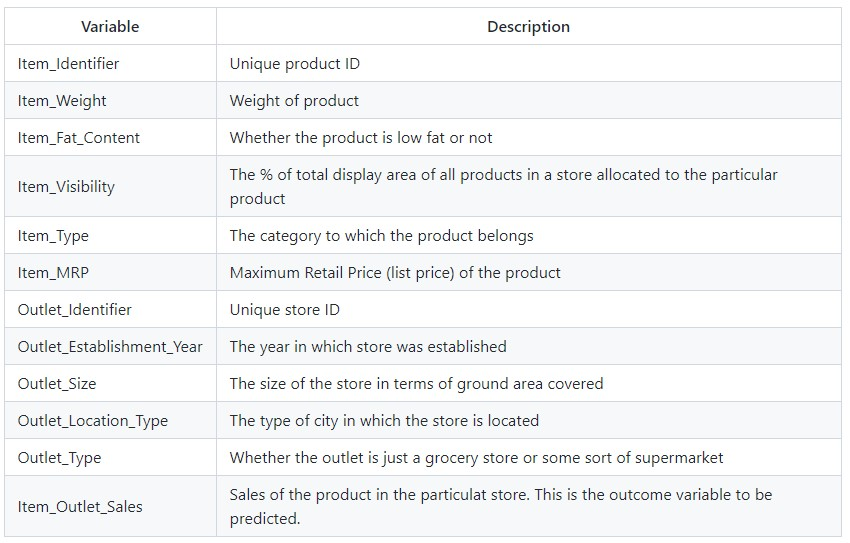

In [3]:
# show item description
Image(filename=DATADIR/'item_description_image.jpg') 

In [4]:
# import data
train_data = pd.read_csv(DATADIR/"train.csv")
train_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
# check data shape
train_data.shape

(8523, 12)

In [6]:
# check data types
train_data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

# Exploratory Data Analysis and Data Preprocessing
## Numerical Features

In [7]:
# First, have a look at numerical values
train_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [8]:
# lets save the numerical features in a list
numerical_features = list(train_data.describe().columns)
numerical_features

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales']

In [9]:
# remove target from feature list
numerical_features.remove('Item_Outlet_Sales')
numerical_features

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

In [10]:
# check null values
train_data[numerical_features].isnull().sum()

Item_Weight                  1463
Item_Visibility                 0
Item_MRP                        0
Outlet_Establishment_Year       0
dtype: int64

In [11]:
# too many null values in Item_Weight; drop this feature
numerical_features.remove('Item_Weight')
numerical_features

['Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

In [12]:
# feature engineering: lets construct an age column i.e. 2013 minus Outlet_Establishment_Year
train_data['Outlet_Age'] = 2013 - train_data['Outlet_Establishment_Year']
train_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,14
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,4
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,14
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,15
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,26


In [13]:
# let´s add the Outlet_Age feature to the list of numerical features
numerical_features.append('Outlet_Age')
numerical_features 

['Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Outlet_Age']

In [14]:
# lets have a look at the correlation amongst the numerical features
corr_mat = train_data[numerical_features].corr()
corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)

,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Age
Item_Visibility,1.00,-0.00,-0.07,0.07
Item_MRP,-0.00,1.00,0.01,-0.01
Outlet_Establishment_Year,-0.07,0.01,1.00,-1.00
Outlet_Age,0.07,-0.01,-1.00,1.00


In [15]:
# sure by construction the feature 'Outlet_Age' is negatively correlated with 'Outlet_Establishment_Year'; hence, drop the latter feature
numerical_features.remove('Outlet_Establishment_Year')
numerical_features

['Item_Visibility', 'Item_MRP', 'Outlet_Age']

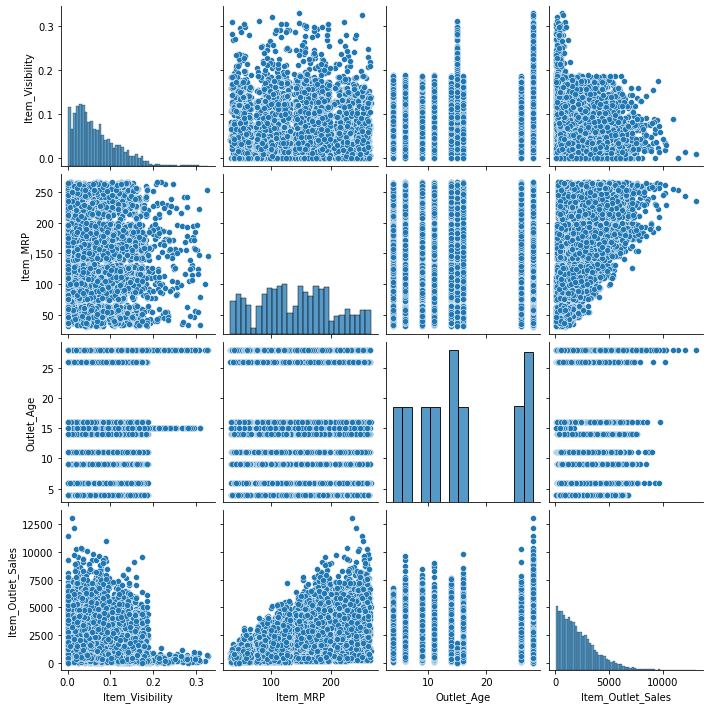

In [16]:
# lets have a look at the distributions of the features and the target 
sns.pairplot(train_data[numerical_features + ['Item_Outlet_Sales']])
plt.show()

***
## Analysis of the numerical features yields:

### 1. we see that we got rather no significant correlations between the numerical features, so let´s stick to all of them;
### 2. we see only weak linear correlations between the target and the Item_MRO feature
### 3. another thing we can do is logarithm-ing the "Item Visibility" and the "Item_Outlet_Sales" to get more of a bell-shaped dist potentially enabling us to use some linear regression stuff
### 4. the last issue it the scaling of the numerical features and the target vars potentially enabling us to use some deep learning stuff

***

In [17]:
# first, let log the target column
train_data['Item_Outlet_Sales'] = utils.my_log_fun(train_data['Item_Outlet_Sales'])
# second, lets log the 'Item_Visibility' column
train_data['Item_Visibility'] = utils.my_log_fun(train_data['Item_Visibility'])


In [18]:
# scale numeric features
feature_scaler = MinMaxScaler()
train_data[numerical_features] = feature_scaler.fit_transform(train_data[numerical_features])

# scale target
target_scaler = MinMaxScaler()
train_data['Item_Outlet_Sales'] = target_scaler.fit_transform(train_data['Item_Outlet_Sales'].values.reshape(-1, 1))

# Exploratory Data Analysis and Data Preprocessing
## Categorical Features

In [19]:
categorical_features = ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

Item_Identifier


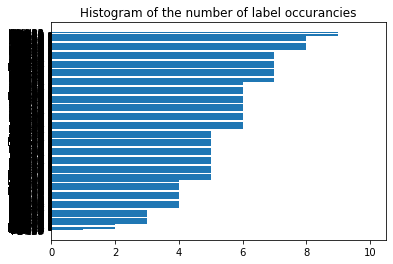

Item_Fat_Content


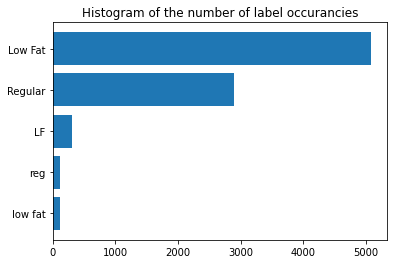

Item_Type


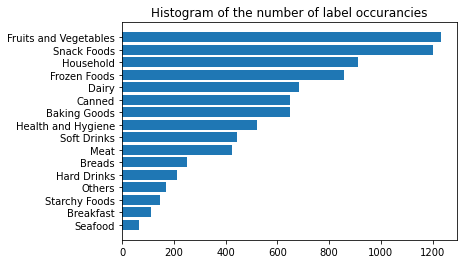

Outlet_Identifier


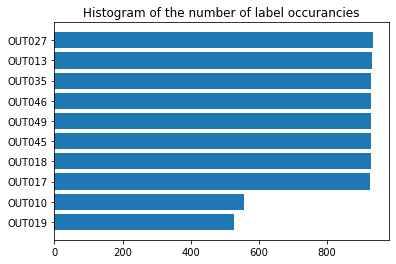

Outlet_Size


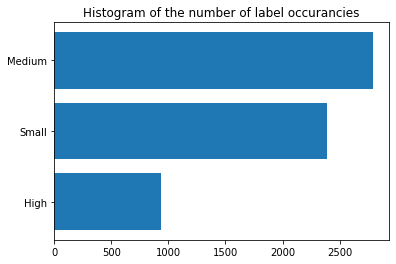

Outlet_Location_Type


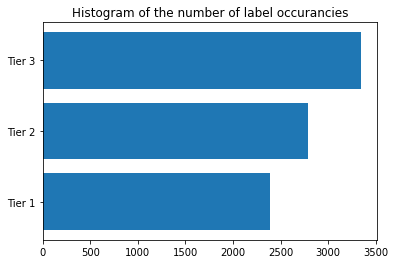

Outlet_Type


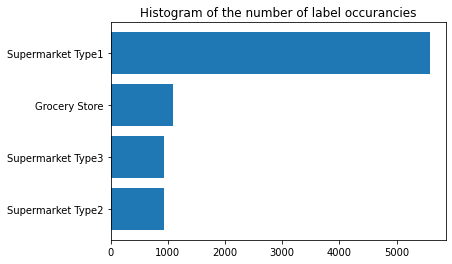

In [20]:
for feature in categorical_features:
    print(feature)
    utils.plot_label_occurancies(train_data, feature)

***
## Analysis of the categorical features yields:

### 1. The feature "Item_Identifier" has way too many labels with correspondingly very rare occurancies; Hence, we drop it
### 2. The feature "Item_Fat_Content" has 5 categories while cat "Low Fat" is the same as "LF" is same as "low fat" and cat "regular" is same as "Regular"; Hence, let´s reduce it!
### 3. The remaining features look in pretty good shape. Let´s leave them as they are

***

In [21]:
# lets remove the "Item_Identifier" feature
categorical_features.remove('Item_Identifier')
categorical_features

['Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [22]:
# remap the labels in the "Item_Fat_Content" column
mapping = {'Low Fat': 'LF', 'low fat': 'LF', 'Regular': 'Reg', 'reg': 'Reg'}
train_data['Item_Fat_Content'] = train_data['Item_Fat_Content'].map(mapping)

Item_Fat_Content


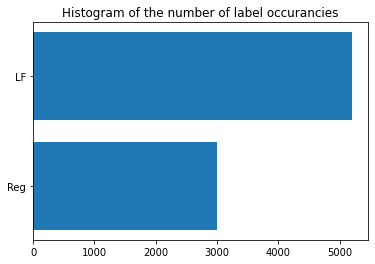

Item_Type


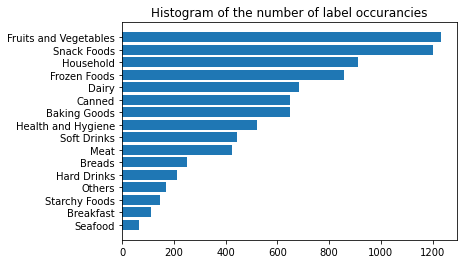

Outlet_Identifier


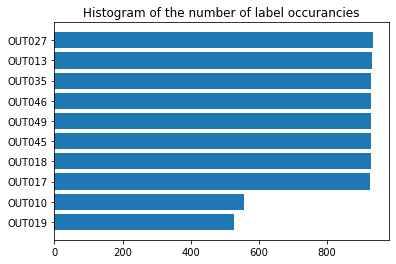

Outlet_Size


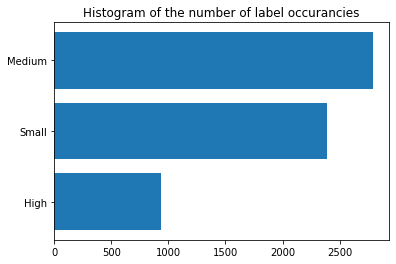

Outlet_Location_Type


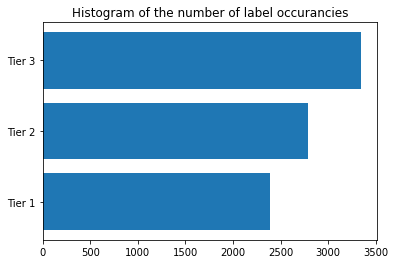

Outlet_Type


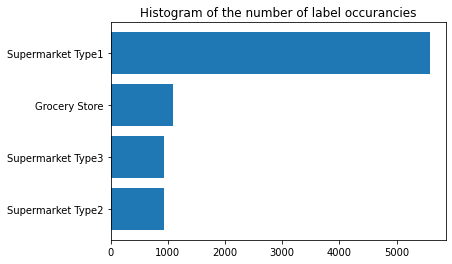

In [23]:
for feature in categorical_features:
    print(feature)
    utils.plot_label_occurancies(train_data, feature)

***
## Analysis of the categorical features yields:

### The category label distributions look pretty decent by now; let´s have a look at the potential effect of the category labels on the sales using boxplots

### we have to be careful considering that we already loghed and max-min transformed the target column; hence, we have to temporarely do the inverse transform plus inverse loghing when looking at the boxplot; lets contruct the inverse trans-log-fun (see utils.py)

***

In [24]:
# inverse transform the target column
y = train_data['Item_Outlet_Sales'].values.reshape(-1,1)
y_trans = utils.my_inverse_log_trans_fun(target_scaler, y).reshape(-1)

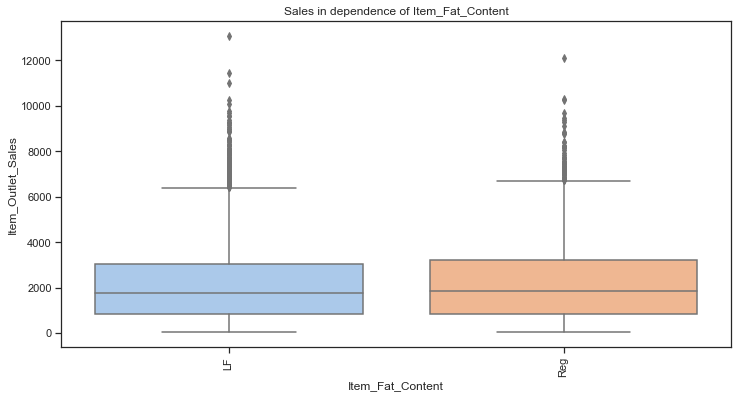

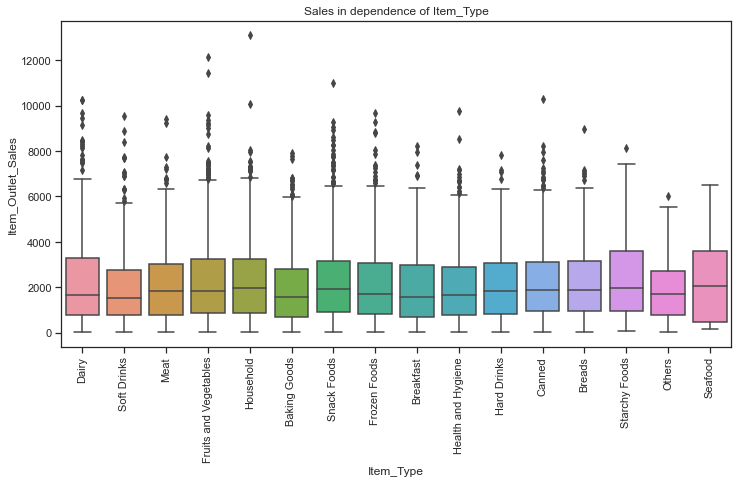

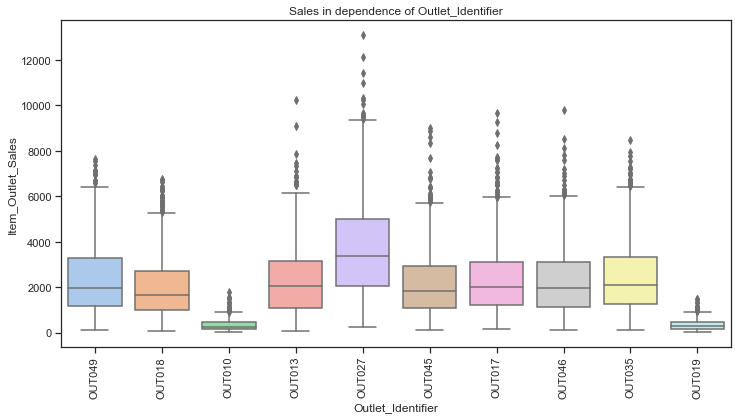

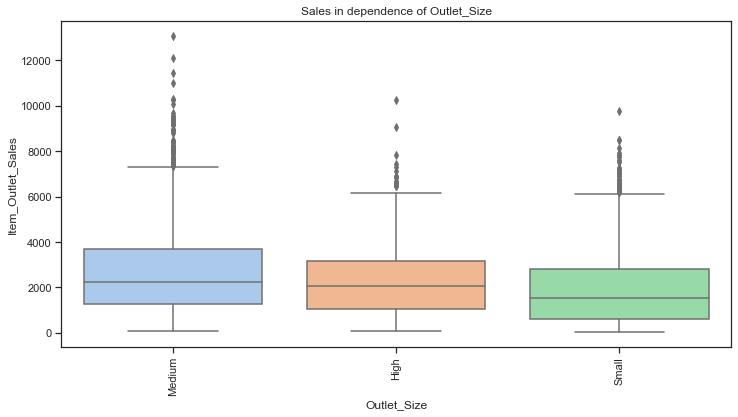

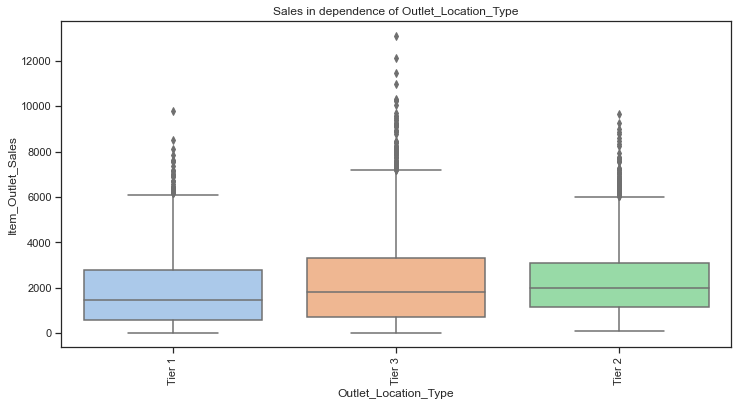

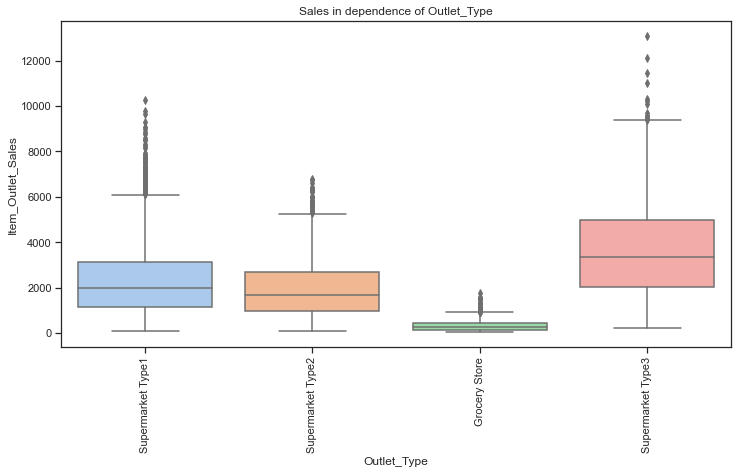

In [25]:
# do the boxplots
for feature in categorical_features:
    plt.figure(figsize=(12,6))
    sns.set_theme(style="ticks", palette="pastel")
    sns.boxplot(x=feature, y=y_trans, data=train_data)
    plt.title('Sales in dependence of '+feature)
    plt.ylabel('Item_Outlet_Sales')
    plt.xticks(rotation='vertical')
    plt.show()


***
## Analysis of the boxplots yields:

### 1. we see a minor effect of the Outlet_Identifier (i.e. OUT027) on the target
### 2. we see some more pronounced effect of the Outlet_Type (i.e. Supermarket Type3) on the target

***

# Exploratory Data Analysis and Data Preprocessing
## Hot-Encoding

In [ ]:
# The category label distributions look pretty decent by now; let´s hot-encode and we are ready to go for the fun part!
train_data = pd.concat([train_data[numerical_features], pd.get_dummies(train_data[categorical_features]), train_data['Item_Outlet_Sales']], axis=1)
train_data.head() 

# Modeling
## Feature Selection

In [27]:
# Lets compare three different modeling techniques i.e. linear regression, gradient boosted trees and of course a neural network
# first of all, do some feature reduction since we ended up with 41 features after hot-encoding 

In [28]:
# Select features, X, and target, y
X = train_data.iloc[:,:-1]
y = train_data.iloc[:,-1]

In [29]:
# get new feature names after hot-encoding
feature_names = list(X.columns) 

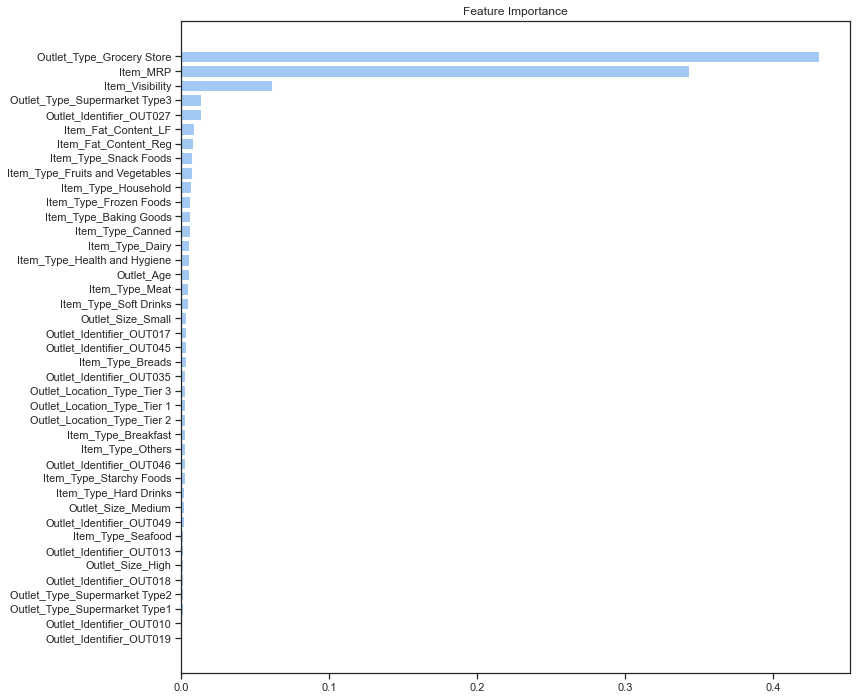

In [30]:
## Let´s apply a tree based feature selection algorithm as proposed by scikit-learn documentation (https://scikit-learn.org/stable/modules/feature_selection.html)
reg = ExtraTreesRegressor(n_estimators=50)
reg = reg.fit(X, y)
# get feature importance df and make a barplot
feature_importance_df = utils.make_feature_importance_df(reg, feature_names)
utils.plot_feature_importance(feature_importance_df)

***
## Analysis of the feature importance chart yields:

### 1. we find three relevant feature influencing with product sales this is Outlet_Type_Grocery Store, Item_MRP, Item_Visibility; it seems to matter more whether its a grocery store or not rather than the type of supermarket incase it is not a grocery store; at least very plausible are the findings that the item´s price and visibility matter;
### 2. the importance of the remaining features is comparably small; however, let´s go for the first ten features since also small feature contributions can potentially increase the model performance by at least a bit. 
***

In [31]:
# reduce the number of features to ten
feature_names = list(feature_importance_df[-10:].index)
# lets drop the remaining features
X = X[feature_names]
X.head()

,Item_Type_Household,Item_Type_Fruits and Vegetables,Item_Type_Snack Foods,Item_Fat_Content_Reg,Item_Fat_Content_LF,Outlet_Identifier_OUT027,Outlet_Type_Supermarket Type3,Item_Visibility,Item_MRP,Outlet_Type_Grocery Store
0,0,0,0,0,1,0,0,0.056062,0.927507,0
1,0,0,0,1,0,0,0,0.067243,0.072068,0
2,0,0,0,0,1,0,0,0.058532,0.468288,0
3,0,1,0,1,0,0,0,0.000000,0.640093,1
4,1,0,0,0,1,0,0,0.000000,0.095805,0


## Train-Test Split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

## Linear Regression
 lets do the final modeling; first try a simple linear model for high interpretability 

In [33]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [34]:
reg.coef_

array([ 1.26499478e-03,  2.99769791e-03,  3.13219359e-03, -2.72494509e-03,
       -3.73410556e-03,  4.69643917e+11, -4.69643917e+11, -6.37130132e-03,
        3.27164327e-01, -3.23990605e-01])

In [35]:
reg.score(X_train,y_train)

0.7116070386326727

In [36]:
reg.score(X_test,y_test)

0.726070697121989

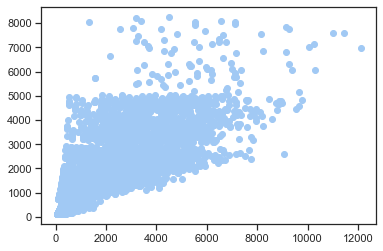

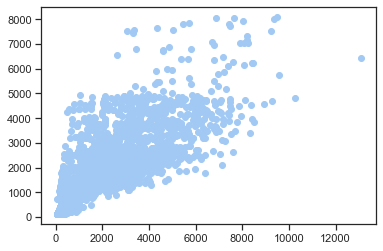

In [37]:
# predict on training set
y_train_pred = reg.predict(X_train)
plt.scatter(utils.my_inverse_log_fun(target_scaler.inverse_transform(y_train.values.reshape(-1,1))), 
            utils.my_inverse_log_fun(target_scaler.inverse_transform(y_train_pred.reshape(-1,1))))
plt.show()

# predict on test set
y_test_pred = reg.predict(X_test)
plt.scatter(utils.my_inverse_log_fun(target_scaler.inverse_transform(y_test.values.reshape(-1,1))), 
            utils.my_inverse_log_fun(target_scaler.inverse_transform(y_test_pred.reshape(-1,1))))
plt.show()

## Gradient Boosted Tree
 lets go for performance with less interpretability 

In [38]:
from sklearn.ensemble import GradientBoostingRegressor
gbreg = GradientBoostingRegressor()
gbreg.fit(X_train, y_train)

GradientBoostingRegressor()

In [39]:
gbreg.feature_importances_

array([3.65025948e-04, 1.51446530e-04, 5.13074769e-04, 1.71092293e-04,
       1.98712382e-04, 1.26231826e-02, 2.26016222e-02, 7.10581555e-03,
       3.91176490e-01, 5.65093537e-01])

In [40]:
gbreg.score(X_train,y_train)

0.7530279996546898

In [41]:
gbreg.score(X_test,y_test)

0.7386794310942966

In [42]:
utils.my_inverse_log_fun(target_scaler.inverse_transform(y_train.values.reshape(-1,1)))

array([[2911.546 ],
       [5692.5926],
       [1257.033 ],
       ...,
       [ 593.2304],
       [1456.1072],
       [ 920.804 ]])

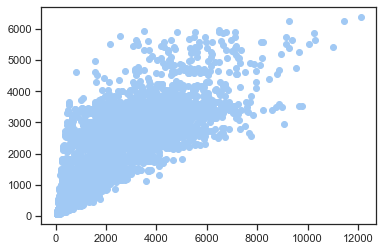

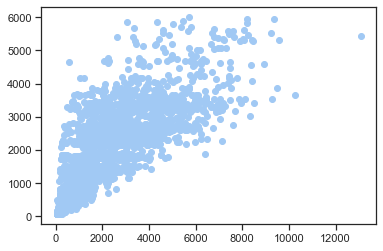

In [43]:
# predict on training set
y_train_pred = gbreg.predict(X_train)
plt.scatter(utils.my_inverse_log_fun(target_scaler.inverse_transform(y_train.values.reshape(-1,1))), 
            utils.my_inverse_log_fun(target_scaler.inverse_transform(y_train_pred.reshape(-1,1))))
plt.show()

# predict on test set
y_test_pred = gbreg.predict(X_test)
plt.scatter(utils.my_inverse_log_fun(target_scaler.inverse_transform(y_test.values.reshape(-1,1))), 
            utils.my_inverse_log_fun(target_scaler.inverse_transform(y_test_pred.reshape(-1,1))))
plt.show()